Simple gradient-based quadratic classification model to compute $W$. 

In [6]:
# ! pip install torch scikit-learn matplotlib -q

In [7]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import seaborn as sns
from pathlib import Path
import matplotlib.gridspec as gridspec

sys.path.append("..")

from src.models.quadratic import QuadraticModel, QuadMLP
from src.models.trainer import ModelTrainer
from src.config.config import cfg


np.set_printoptions(precision=2, suppress=True, linewidth=120)


In [8]:

# Configuration
hyp = {
    "data_paths": [
        "../data/encoded/S21_encoded_with_outcomes.csv",
        "../data/encoded/W21_encoded_with_outcomes.csv",
        "../data/encoded/S17_encoded_with_outcomes.csv",
        "../data/encoded/W17_encoded_with_outcomes.csv",
        "../data/encoded/top_companies_encoded_with_outcomes.csv"
    ],
    "synthetic_data_path": '../data/synth/encoded_founders_composites.csv',
    "test_size": 0.1,
    "val_size": 0.1,
    "random_state": 42,
    "batch_size": 32,
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "epochs": 400,
    "patience": 30,
    "lr_decay_factor": 0.3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "exclude_columns": ["success", "exit_value", "funding_amount", "batch"],
    "target_column": "success",
    "diag_penalty": 0.005,
    "l1_penalty": 0.0005,
    "top_k_penalty": 0.005,
    "top_k": 10,
    "log_every": 5
}


In [11]:

def load_and_preprocess_data(hyp):
   
    real_data = pd.concat([
        pd.read_csv(path).assign(batch=path.split('/')[-1].split('_')[0]) 
        for path in hyp["data_paths"]
    ])
    

    synthetic_data = pd.read_csv(hyp["synthetic_data_path"]) if hyp["synthetic_data_path"] else None
    if synthetic_data is not None:
        synthetic_data['batch'] = 'synthetic'
    
    feature_columns = [col for col in real_data.columns if col not in hyp["exclude_columns"]]
    
    
    X_real = real_data[feature_columns].to_numpy()
    y_real = real_data[hyp["target_column"]].values
    
   
    X_real_train, X_test, y_real_train, y_test = train_test_split(
        X_real, y_real,
        test_size=hyp["test_size"],
        random_state=hyp["random_state"],
        stratify=y_real
    )

    
    X_train, X_val, y_train, y_val = train_test_split(
        X_real_train, y_real_train,
        test_size=hyp["val_size"],
        random_state=hyp["random_state"],
        stratify=y_real_train
    )

    if synthetic_data is not None:
        X_synth = synthetic_data[feature_columns].to_numpy()
        y_synth = synthetic_data[hyp["target_column"]].values
        X_train = np.vstack([X_train, X_synth])
        y_train = np.concatenate([y_train, y_synth])
        is_synthetic = np.concatenate([np.zeros(len(X_train) - len(X_synth)), np.ones(len(X_synth))])
        
        print("\nData Split Summary:")
        print(f"Real data: {len(X_real)} samples")
        print(f"Synthetic data: {len(X_synth)} samples")
        print(f"\nTrain set: {len(X_train)} samples ({sum(is_synthetic == 0)} real, {sum(is_synthetic == 1)} synthetic)")
        print(f"Val set: {len(X_val)} samples (all real)")
        print(f"Test set: {len(X_test)} samples (all real)")
        
        print(f"\nClass distribution:")
        print(f"Train set - Real: {sum(y_train[is_synthetic == 0] == 1)}/{sum(is_synthetic == 0)} positive")
        print(f"Train set - Synthetic: {sum(y_train[is_synthetic == 1] == 1)}/{sum(is_synthetic == 1)} positive")
        print(f"Val set: {sum(y_val == 1)}/{len(y_val)} positive")
        print(f"Test set: {sum(y_test == 1)}/{len(y_test)} positive")
    else:
        is_synthetic = np.zeros(len(X_train))
        
        print("\nData Split Summary (No synthetic data):")
        print(f"Total data: {len(X_real)} samples")
        print(f"\nTrain set: {len(X_train)} samples")
        print(f"Val set: {len(X_val)} samples")
        print(f"Test set: {len(X_test)} samples")
        
        print(f"\nClass distribution:")
        print(f"Train set: {sum(y_train == 1)}/{len(y_train)} positive")
        print(f"Val set: {sum(y_val == 1)}/{len(y_val)} positive")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to tensors
    tensors = {
        'train': (
            torch.FloatTensor(X_train_scaled),
            torch.FloatTensor(y_train),
            torch.FloatTensor(is_synthetic)
        ),
        'val': (
            torch.FloatTensor(X_val_scaled),
            torch.FloatTensor(y_val)
        ),
        'test': (
            torch.FloatTensor(X_test_scaled),
            torch.FloatTensor(y_test)
        )
    }
    
    return tensors, feature_columns, scaler

def create_model_and_trainer(input_dim, hyp, pos_weight):
    model = QuadMLP(input_dim)
    model = model.to(hyp['device'])
    trainer = ModelTrainer(model, hyp, pos_weight)
    return model, trainer

def plot_model_performance(trainer, W_init):
    plt.style.use('seaborn-v0_8-dark') 
    
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])
    
    epochs = range(len(trainer.train_loss_history))
    
    # Loss curves
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(epochs, trainer.train_loss_history, label='Train', color='#2ecc71', linewidth=2)
    ax1.plot(epochs, trainer.val_loss_history, label='Val', color='#3498db', linewidth=2)
    ax1.plot(epochs, trainer.test_loss_history, label='Test', color='#e74c3c', linewidth=2)
    ax1.set_title('Training Loss', fontsize=14, pad=15)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Accuracy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(epochs, trainer.train_accuracy_history, label='Train', color='#2ecc71', linewidth=2)
    ax2.plot(epochs, trainer.val_accuracy_history, label='Val', color='#3498db', linewidth=2)
    ax2.plot(epochs, trainer.test_accuracy_history, label='Test', color='#e74c3c', linewidth=2)
    ax2.set_title('Classification Accuracy', fontsize=14, pad=15)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    # ROC-AUC
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(epochs, trainer.train_auc_history, label='Train', color='#2ecc71', linewidth=2)
    ax3.plot(epochs, trainer.val_auc_history, label='Val', color='#3498db', linewidth=2)
    ax3.plot(epochs, trainer.test_auc_history, label='Test', color='#e74c3c', linewidth=2)
    ax3.set_title('ROC-AUC Score', fontsize=14, pad=15)
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('AUC', fontsize=12)
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)

    # NDCG & P@K
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(epochs, trainer.train_ndcg_history, label='NDCG Train', color='#2ecc71', linewidth=2)
    ax4.plot(epochs, trainer.val_ndcg_history, label='NDCG Val', color='#3498db', linewidth=2)
    ax4.plot(epochs, trainer.test_ndcg_history, label='NDCG Test', color='#e74c3c', linewidth=2)
    ax4.plot(epochs, trainer.train_precision_history, label='P@K Train', color='#2ecc71', linestyle='--', linewidth=2)
    ax4.plot(epochs, trainer.val_precision_history, label='P@K Val', color='#3498db', linestyle='--', linewidth=2)
    ax4.plot(epochs, trainer.test_precision_history, label='P@K Test', color='#e74c3c', linestyle='--', linewidth=2)
    ax4.set_title('Ranking Metrics (NDCG & P@K)', fontsize=14, pad=15)
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('Score', fontsize=12)
    ax4.legend(fontsize=10, ncol=2)
    ax4.grid(True, alpha=0.3)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)


    W_final = trainer.model.get_W().detach().cpu().numpy()
    W_diff = W_final - W_init  
    
    gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1.2])

    ax5 = fig.add_subplot(gs[2, 0])
    vmax = max(abs(W_init).max(), abs(W_final).max())  
    im1 = ax5.imshow(W_init, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
    ax5.set_title('Initial Weight Matrix', fontsize=14, pad=15)
    plt.colorbar(im1, ax=ax5)
    ax5.set_xlabel('Feature Index', fontsize=12)
    ax5.set_ylabel('Feature Index', fontsize=12)

    ax6 = fig.add_subplot(gs[2, 1])
    im2 = ax6.imshow(W_final, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
    ax6.set_title('Final Weight Matrix', fontsize=14, pad=15)
    plt.colorbar(im2, ax=ax6)
    ax6.set_xlabel('Feature Index', fontsize=12)
    ax6.set_ylabel('Feature Index', fontsize=12)

    ax7 = fig.add_subplot(gs[2, 2])
    vmax_diff = abs(W_diff).max() 
    im3 = ax7.imshow(W_diff, cmap='RdBu_r', aspect='auto', vmin=-vmax_diff, vmax=vmax_diff)
    ax7.set_title('Weight Change (Final - Initial)', fontsize=14, pad=15)
    plt.colorbar(im3, ax=ax7)
    ax7.set_xlabel('Feature Index', fontsize=12)
    ax7.set_ylabel('Feature Index', fontsize=12)
    plt.tight_layout()
    plt.show()
    

def plot_ranked_feature_importance(W, feature_names, figsize=(15, 10)):
    plt.style.use('seaborn-v0_8-dark')
    
    # Get diagonal importance (individual feature effects)
    diag_importance = np.abs(np.diag(W))
    diag_ranks = pd.DataFrame({
        'Feature': feature_names,
        'Importance': diag_importance,
        'Type': 'Individual'
    })
    
    # Get interaction importance (sum of absolute off-diagonal elements)
    interaction_importance = []
    for i, feat in enumerate(feature_names):
        # Sum absolute values of off-diagonal elements for each feature
        importance = np.sum(np.abs(W[i, :])) + np.sum(np.abs(W[:, i])) - 2*np.abs(W[i,i])
        interaction_importance.append(importance)
    
    interaction_ranks = pd.DataFrame({
        'Feature': feature_names,
        'Importance': interaction_importance,
        'Type': 'Interaction'
    })
    
    # Combine and normalize
    all_ranks = pd.concat([diag_ranks, interaction_ranks])
    all_ranks['Importance'] = all_ranks.groupby('Type')['Importance'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Individual importance
    individual = all_ranks[all_ranks['Type'] == 'Individual'].sort_values('Importance', ascending=True)
    ax1.barh(range(len(individual)), individual['Importance'], color='#2ecc71', alpha=0.7)
    ax1.set_yticks(range(len(individual)))
    ax1.set_yticklabels(individual['Feature'], fontsize=10)
    ax1.set_title('Individual Feature Importance', fontsize=14, pad=15)
    ax1.set_xlabel('Normalized Importance', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Interaction importance
    interaction = all_ranks[all_ranks['Type'] == 'Interaction'].sort_values('Importance', ascending=True)
    ax2.barh(range(len(interaction)), interaction['Importance'], color='#3498db', alpha=0.7)
    ax2.set_yticks(range(len(interaction)))
    ax2.set_yticklabels(interaction['Feature'], fontsize=10)
    ax2.set_title('Feature Interaction Importance', fontsize=14, pad=15)
    ax2.set_xlabel('Normalized Importance', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Return top 5 features for each type
    top_individual = individual.tail(5)['Feature'].tolist()[::-1]
    top_interaction = interaction.tail(5)['Feature'].tolist()[::-1]
    
    print("\nTop 5 Individual Features:")
    for i, feat in enumerate(top_individual, 1):
        print(f"{i}. {feat}")
        
    print("\nTop 5 Interactive Features:")
    for i, feat in enumerate(top_interaction, 1):
        print(f"{i}. {feat}")
    
def plot_feature_importance(W, feature_names, figsize=(12, 10)):
    plt.style.use('seaborn-v0_8-dark')
    
    
    mask = np.zeros_like(W, dtype=bool)
    mask[np.triu_indices_from(mask, k=1)] = True
    

    fig, ax = plt.subplots(figsize=figsize)
    
  
    vmax = np.abs(W).max()
    sns.heatmap(W, 
                mask=mask,
                cmap='coolwarm',
                center=0,
                vmin=-vmax,
                vmax=vmax,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8},
                xticklabels=feature_names,
                yticklabels=feature_names,
                ax=ax)
    
    
    plt.title('Feature Interaction Importance', fontsize=14, pad=15)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
 
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()




Data Split Summary:
Real data: 1386 samples
Synthetic data: 1000 samples

Train set: 2122 samples (1122 real, 1000 synthetic)
Val set: 125 samples (all real)
Test set: 139 samples (all real)

Class distribution:
Train set - Real: 408/1122 positive
Train set - Synthetic: 577/1000 positive
Val set: 46/125 positive
Test set: 51/139 positive
Starting training...
Epoch Train Loss   Val Loss  Test Loss Train Acc   Val Acc  Test Acc  Val AUC Test AUC     NDCG      P@K
----------------------------------------------------------------------------------------------------
    0    47.3330    40.6003    45.7653    0.4642    0.3680    0.3669   0.5000   0.5000   0.7536   0.4000
    5    45.1284    38.1773    43.2807    0.4642    0.3680    0.3669   0.5000   0.5000   0.7536   0.4000
   10    43.3914    36.3057    41.3583    0.4642    0.3680    0.3669   0.5000   0.5000   0.7536   0.4000
   15    41.7224    34.5149    39.5138    0.4642    0.3680    0.3669   0.5000   0.5000   0.7536   0.4000
   20    40.

/var/folders/0h/b0b6qlp97wxd6bw8pzg5jm280000gq/T/ipykernel_8141/760880193.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


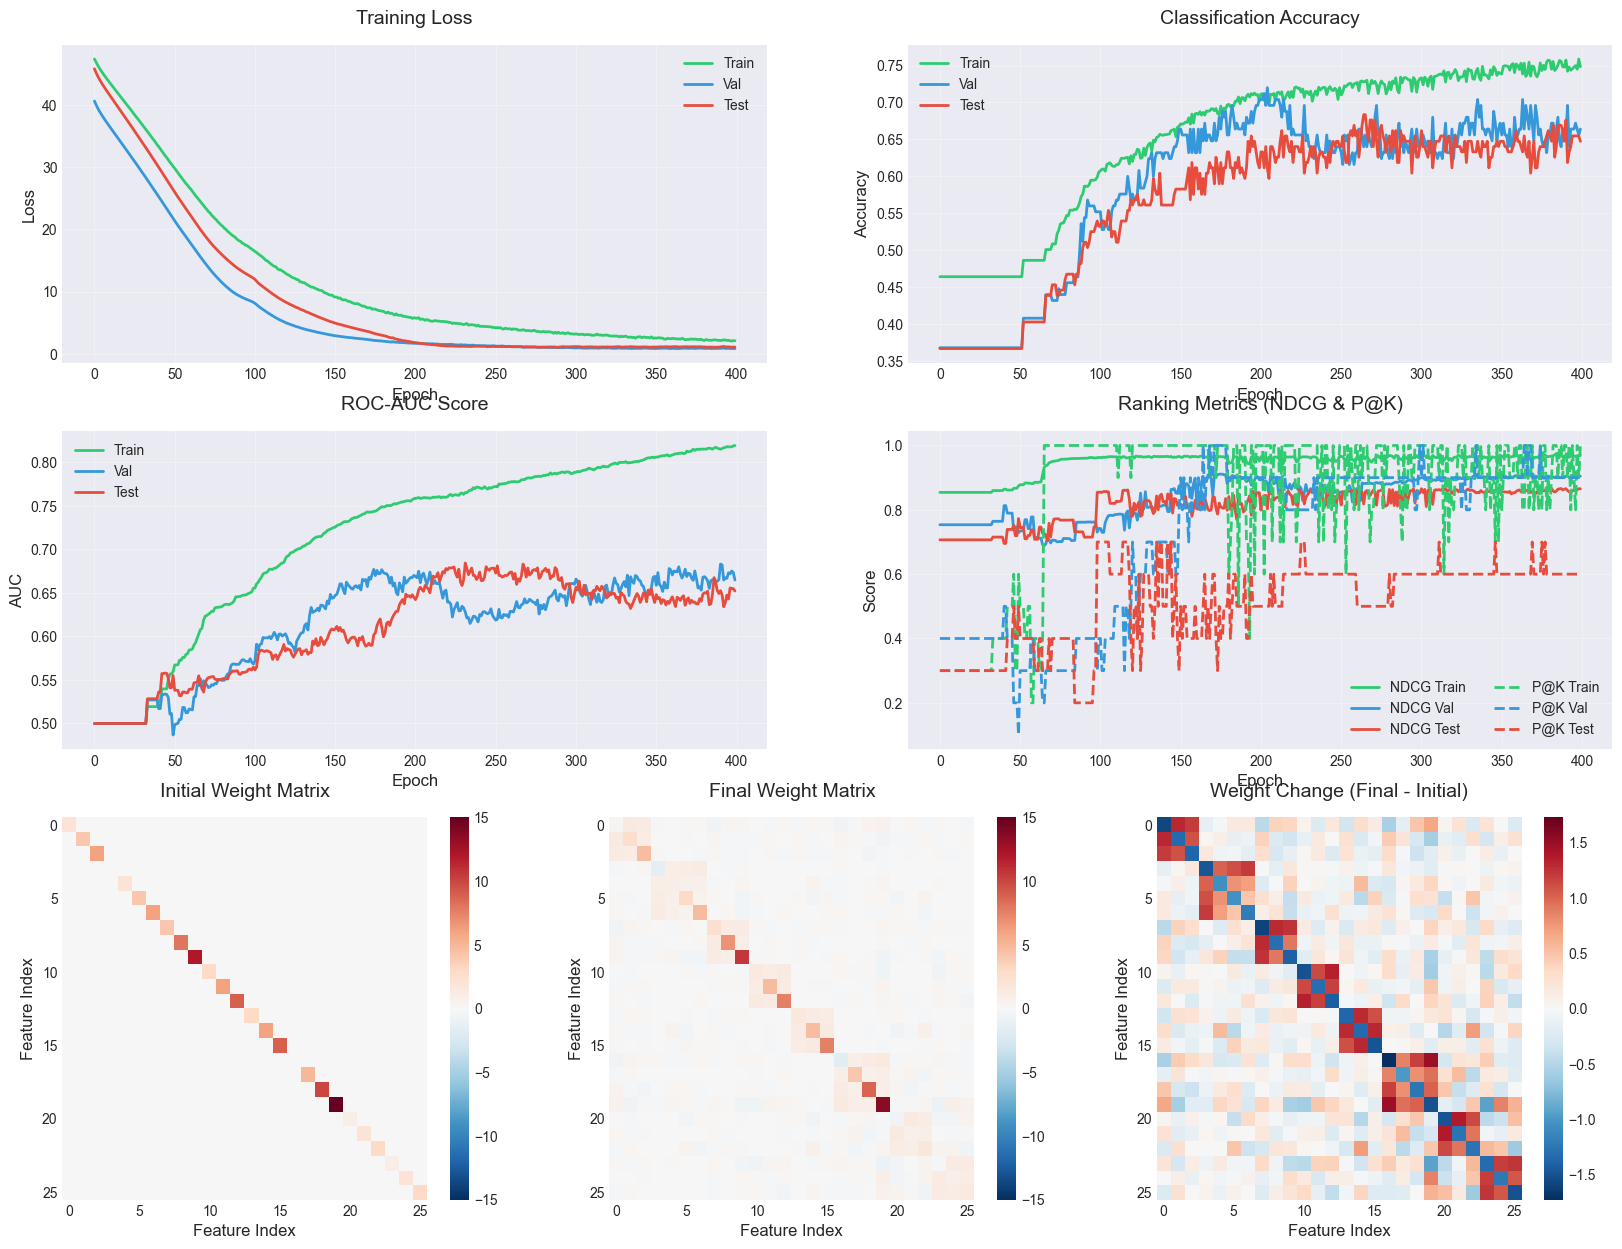

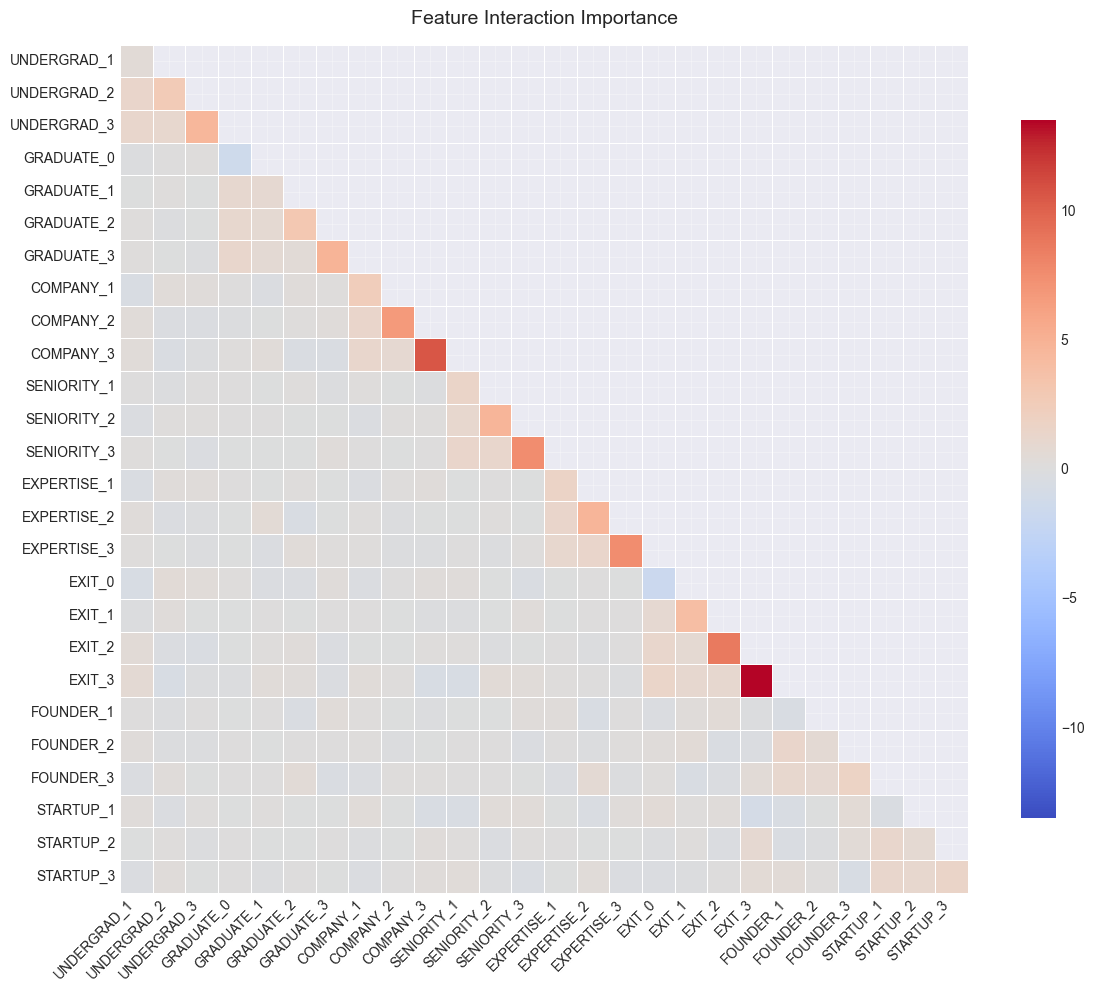

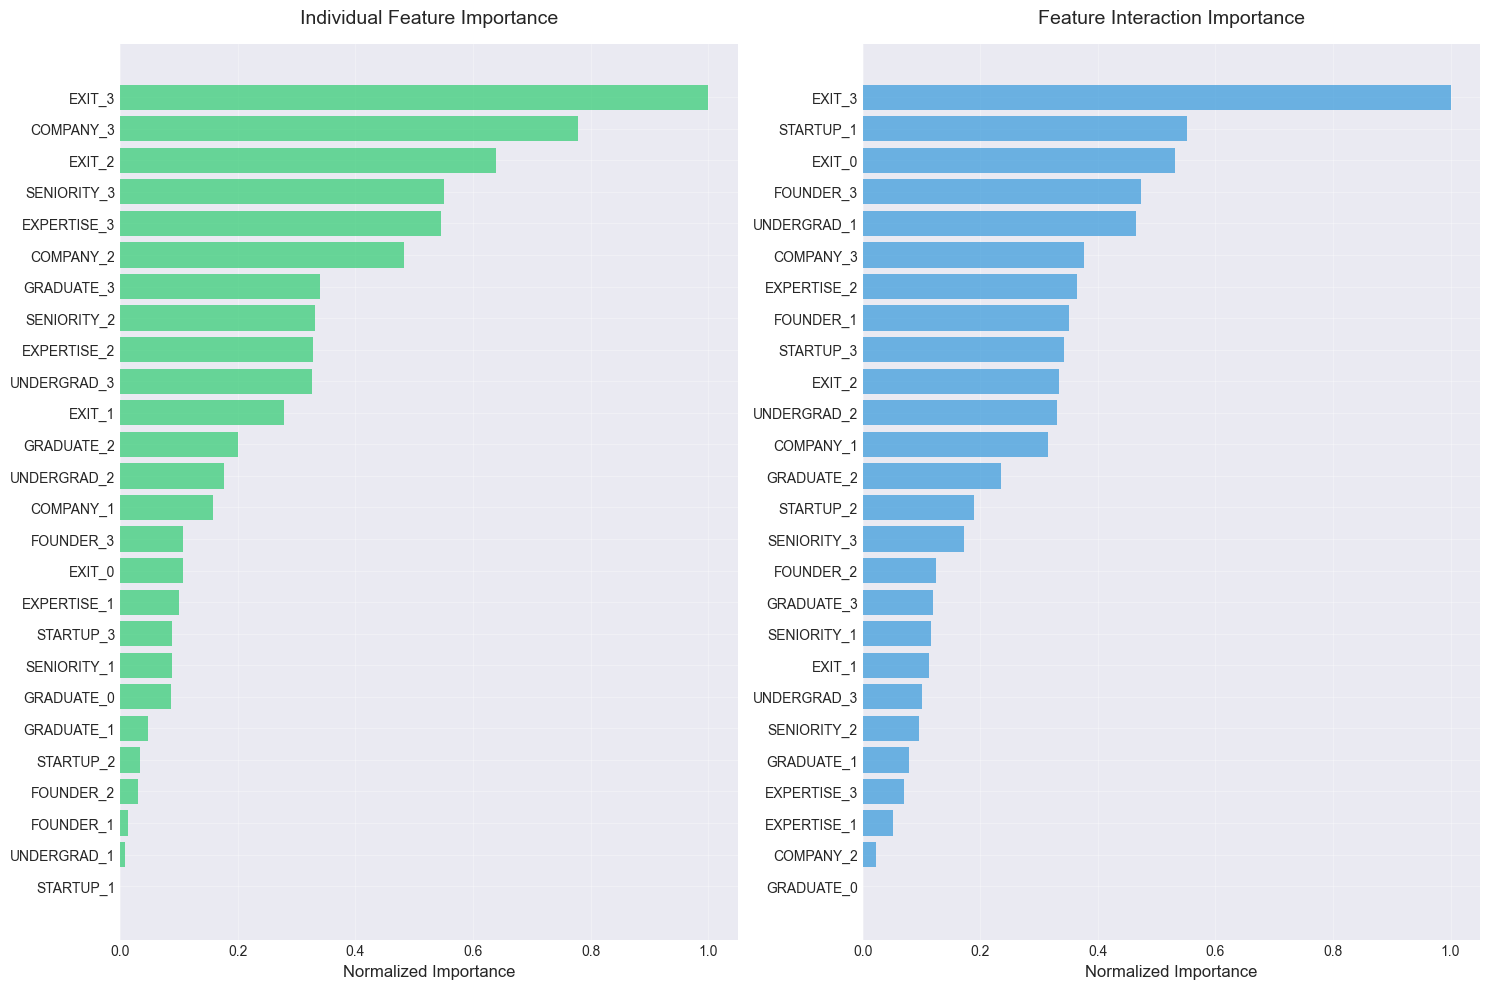


Top 5 Individual Features:
1. EXIT_3
2. COMPANY_3
3. EXIT_2
4. SENIORITY_3
5. EXPERTISE_3

Top 5 Interactive Features:
1. EXIT_3
2. STARTUP_1
3. EXIT_0
4. FOUNDER_3
5. UNDERGRAD_1

Training Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77      1137
         1.0       0.74      0.71      0.72       985

    accuracy                           0.75      2122
   macro avg       0.75      0.75      0.75      2122
weighted avg       0.75      0.75      0.75      2122


Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.76      0.74        79
         1.0       0.55      0.50      0.52        46

    accuracy                           0.66       125
   macro avg       0.64      0.63      0.63       125
weighted avg       0.66      0.66      0.66       125


Test Set Classification Report:
              precision    recall  f1-score   support

 

In [12]:
def main():

    tensors, feature_names, scaler = load_and_preprocess_data(hyp)
    

    X_train_tensor, y_train_tensor, is_synthetic_train_tensor = tensors['train']
    X_val_tensor, y_val_tensor = tensors['val']
    X_test_tensor, y_test_tensor = tensors['test']
    
    
    n_neg = (y_train_tensor == 0).sum()
    n_pos = (y_train_tensor == 1).sum()
    pos_weight = torch.tensor([n_neg / n_pos])

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor, is_synthetic_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=hyp["batch_size"], shuffle=True)
    

    input_dim = X_train_tensor.shape[1]
    model, trainer = create_model_and_trainer(input_dim, hyp, pos_weight)
    

    print("Starting training...")
    print(f"{'Epoch':>5} {'Train Loss':>10} {'Val Loss':>10} {'Test Loss':>10} {'Train Acc':>9} {'Val Acc':>9} {'Test Acc':>9} {'Val AUC':>8} {'Test AUC':>8} {'NDCG':>8} {'P@K':>8}")
    print("-" * 100)
    
    best_val_auc = float('-inf')
    best_model_state = None
    W_init = model.get_W().detach().cpu().numpy()
    
    for epoch in range(hyp["epochs"]):
    
        train_loss = trainer.train_epoch(train_loader)
        
        
        with torch.no_grad():
            train_metrics = trainer.evaluate(X_train_tensor, y_train_tensor)
            val_metrics = trainer.evaluate(X_val_tensor, y_val_tensor)
            test_metrics = trainer.evaluate(X_test_tensor, y_test_tensor)
        
        
        trainer.train_loss_history.append(train_loss)
        trainer.val_loss_history.append(val_metrics['loss'])
        trainer.test_loss_history.append(test_metrics['loss'])
        
        trainer.train_accuracy_history.append(train_metrics['accuracy'])
        trainer.val_accuracy_history.append(val_metrics['accuracy'])
        trainer.test_accuracy_history.append(test_metrics['accuracy'])
        
        trainer.train_auc_history.append(train_metrics['auc'])
        trainer.val_auc_history.append(val_metrics['auc'])
        trainer.test_auc_history.append(test_metrics['auc'])
        
        trainer.train_ndcg_history.append(train_metrics['ndcg'])
        trainer.val_ndcg_history.append(val_metrics['ndcg'])
        trainer.test_ndcg_history.append(test_metrics['ndcg'])
        
        trainer.train_precision_history.append(train_metrics['precision_at_k'])
        trainer.val_precision_history.append(val_metrics['precision_at_k'])
        trainer.test_precision_history.append(test_metrics['precision_at_k'])
        
   
        if epoch % hyp["log_every"] == 0:
            print(f"{epoch:5d} {train_loss:10.4f} {val_metrics['loss']:10.4f} {test_metrics['loss']:10.4f} "
                    f"{train_metrics['accuracy']:9.4f} {val_metrics['accuracy']:9.4f} {test_metrics['accuracy']:9.4f} "
                    f"{val_metrics['auc']:8.4f} {test_metrics['auc']:8.4f} "
                    f"{val_metrics['ndcg']:8.4f} {val_metrics['precision_at_k']:8.4f}")
        

        if val_metrics['auc'] > best_val_auc:
            best_val_auc = val_metrics['auc']
            best_model_state = model.state_dict()
 
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    W_final = model.get_W().detach().cpu().numpy()
    plot_model_performance(trainer, W_init)
    plot_feature_importance(W_final, feature_names)
    plot_ranked_feature_importance(W_final, feature_names)
    
  
    model_dir = Path("../models")
    model_dir.mkdir(exist_ok=True)
    torch.save({
        'model_state_dict': model.state_dict(),
        'W_init': W_init,
        'W_final': model.get_W().detach().cpu().numpy(),
        'feature_names': feature_names,
        'scaler_state': scaler.__getstate__()
    }, model_dir / "founder_rank.pt")
    
    with torch.no_grad():
        train_preds = (torch.sigmoid(model(X_train_tensor)) > 0.5).cpu().numpy()
        val_preds = (torch.sigmoid(model(X_val_tensor)) > 0.5).cpu().numpy()
        test_preds = (torch.sigmoid(model(X_test_tensor)) > 0.5).cpu().numpy()

    print("\nTraining Set Classification Report:")
    print(classification_report(y_train_tensor.cpu().numpy(), train_preds))
    print("\nValidation Set Classification Report:")
    print(classification_report(y_val_tensor.cpu().numpy(), val_preds))
    print("\nTest Set Classification Report:")
    print(classification_report(y_test_tensor.cpu().numpy(), test_preds))
        
        
    return model, trainer, scaler, W_init, model.get_W().detach().cpu().numpy()

if __name__ == "__main__":
    model, trainer, scaler, W_init, W_final = main()